# Bandits

In this part, we will investigate the properties of the action selection schemes seen in the lecture and compare their properties:

1. greedy action selection
2. $\epsilon$-greedy action selection
3. softmax action selection
4. reinforcement comparison

Let's do some imports:

In [15]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [31]:
class Bandit:
    def __init__(self, nb_arms, mean=0.0, var_Q=1.0, var_r=1.0):
        self.nb_arms = nb_arms
        self.mean = mean
        self.var_Q = var_Q
        self.var_r = var_r
        
        # Initialize the true Q-values
        self.Q_star = rng.normal(self.mean, self.var_Q, self.nb_arms)
        
        # Optimal action
        self.a_star = self.Q_star.argmax()
        
    def step(self, action):
        return float(rng.normal(self.Q_star[action], self.var_r, 1))
        
nb_actions = 5
bandit = Bandit(nb_actions)

4

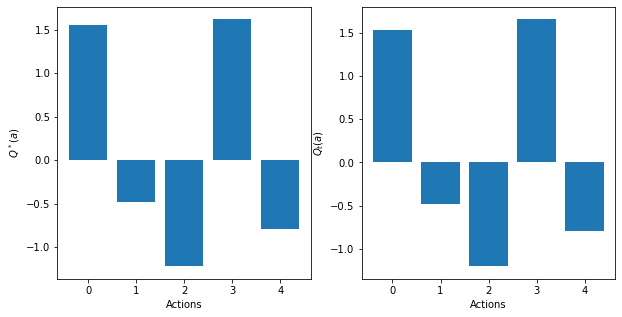

In [24]:
means = []
for a in range(nb_actions):
    rewards = []
    for t in range(1000):
        rewards.append(bandit.step(a))
    means.append(np.mean(rewards))
    
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.bar(np.arange(nb_actions), bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(122)
plt.bar(actions, means)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.show()

## Greedy action selection

In **greedy action selection**, we systematically chose the action with the highest estimated Q-value at each play (or randomly when there are ties):

$$a_t = \text{argmax}_a Q_t(a)$$

We maintain estimates $Q_t$ of the action values (initialized to 0) using the online formula:

$$Q_{t+1}(a_t) = Q_t(a_t) + \alpha \, (r_{t} - Q_t(a_t))$$

when receiving the sampled reward $r_t$ after taking the action $a_t$. The learning rate $\alpha$ can be set to 0.1 at first.

The algorithm simply alternates between these two steps for 1000 plays (or steps): take an action, update its Q-value. 

**Q:** Implement the greedy algorithm on the 5-armed bandit.

Your algorithm will look like this:

* Create a 5-armed bandit (mean of zero, variance of 1).
* Initialize the estimated Q_values to 0 with an array of the same size (call it `Q_greedy` or something like that, not `Q_t`, as we will later make comparisons between the different algorithms).
* **for** 1000 plays:
    * Select the greedy action $a_t^*$ using the current estimates.
    * Sample a reward from $Q^*(a_t^*)$ using the method `get_reward()` (variance of 1).
    * Update the estimated Q-value of the action taken.
    
Additionally, you will store the received rewards at each step in an initially empty list or a numpy array of the correct size and plot it in the end. You will also plot the true Q-values and the estimated Q-values at the end of the 1000 plays. 

*Tip:* to implement the argmax, do not rely on `np.argmax()`. If there are ties in the array, for example at the beginning:

```python
x = np.array([0, 0, 0, 0, 0])
```

`x.argmax()` will return you the **first occurrence** of the maximum 0.0 of the array. In this case it will be the index 0, so you will always select the action 0 first. 

It is much more efficient to retrieve the indices of **all** maxima and randomly select one of them:

```python
a = rng.choice(np.where(x == x.max())[0])
```

`np.where(x == x.max())` returns a list of indices where `x` is maximum. `rng.choice()` randomly selects one of them.

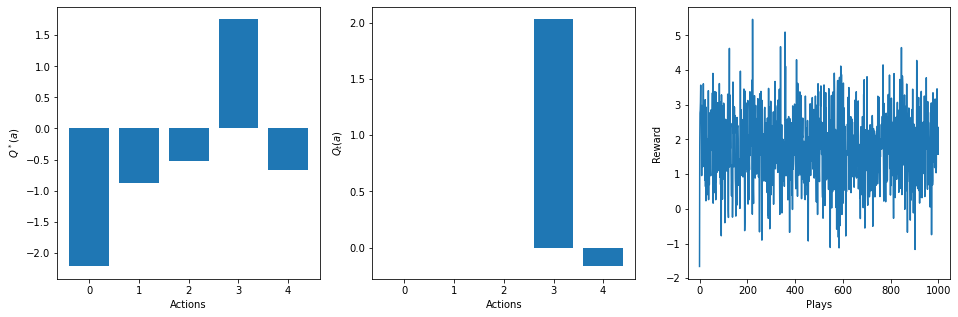

In [27]:
# Learning rate
alpha = 0.1

# Setup 
nb_steps = 1000

# Bandit
bandit = Bandit(nb_actions)

# Estimates
Q_greedy = np.zeros(nb_actions)

# Store the rewards after each step
rewards_greedy = np.zeros(nb_steps)

# For 1000 plays
for step in range(nb_steps):
    
    # Select the action greedily w.r.t Q_t
    a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
    
    # Sample the reward
    r = bandit.step(a)
    
    # Store the received reward
    rewards_greedy[step] = r
    
    # Update the Q-value estimate of the action
    Q_greedy[a] += alpha * (r - Q_greedy[a])
    
# Plot the Q-values and the evolution of rewards
plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.bar(actions, bandit.Q_star)
plt.xlabel("Actions")
plt.ylabel("$Q^*(a)$")
plt.subplot(132)
plt.bar(actions, Q_greedy)
plt.xlabel("Actions")
plt.ylabel("$Q_t(a)$")
plt.subplot(133)
plt.plot(rewards_greedy)
plt.xlabel("Plays")
plt.ylabel("Reward")
plt.show()

**Q:** Re-run your algorithm multiple times with different values of `Q^*` and observe:

1. How much reward you get.
2. How your estimated Q-values in the end differ from the true Q-values.
3. Whether greedy action action selection finds the optimal action or not.

**A:** The plot with rewards is very noisy, you do not really see whether you have learned something because of the randomness of the rewards. More often than not, greedy action selection finds the optimal action, or least a not-that-bad action. The estimates `Q_t` have however nothing to see with the true Q-values, as you quickly select the same action and never update the other ones. 

The evolution of the received rewards does not give a clear indication of the successful learning. To truly estimate the correctness of the algorithm, we have to average these received results ober many runs, e.g. 200.

**Q:** Modify the previous cell to average the results over 200 runs. The true Q-values should be sampled every time. Store each received reward in a big `(200, 1000)` matrix and plot the average received reward in the end.

Another important information, besides the mean received reward, is how often the selected action is the optimal action (which you can obtain with `a_star = np.random.choice(np.where(Q_star == Q_star.max())[0])`). Store this information in another big matrix (1.0 if the selected action is the optimal action, 0.0 otherwise) and plot the average evolution of the optimality.  

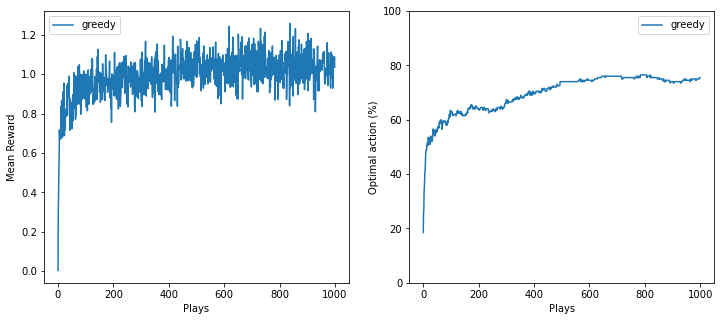

In [4]:
# Learning rate
alpha = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # Select the action greedily w.r.t Q_t
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        
        # Sample the reward
        r = get_reward(Q_star, a)
        
        # Store the received reward
        rewards_greedy[trial, step] = r
        
        # Optimal action?
        if a == a_star:
            optimal_greedy[trial, step] = 1.0            
        
        # Update the Q-value estimate of the action
        Q_greedy[a] += alpha * (r - Q_greedy[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** greedy action selection ends up selecting the optimal action 80% of the time, what is really not bad knowing that it starts at chance level (20% for 5 actions).

## - $\epsilon$-greedy action selection

The main drawback of greedy action selection is that it does not explore: as soon as it finds an action better than the others (with a sufficiently positive true Q-value, i.e. where the sampled rewards are mostly positive), it will keep selecting that action and avoid exploring the other options. 

The estimated Q-value of the selected action will end up being quite correct, but those of the other actions will stay at 0.

In $\epsilon$-greedy action selection, the greedy action $a_t^*$ (with the highest estimated Q-value) will be selected with a probability $1-\epsilon$, the others with a probability of $\epsilon$ altogether. 

$$
    \pi(a) = \begin{cases} 1 - \epsilon \; \text{if} \; a = a_t^* \\ \frac{\epsilon}{|\mathcal{A}| - 1} \; \text{otherwise.} \end{cases}
$$

If you have $|\mathcal{A}| = 5$ actions, the four non-greedy actions will be selected with a probability of $\frac{\epsilon}{4}$.

**Q:** Modify your code to implement $\epsilon$-greedy action selection (with $\epsilon=0.1$ at first). Do not overwrite the arrays previously calculated (mean reward and optimal actions), as you will want to compare the two methods in a single plot.

To implement $\epsilon-$greedy, you need to:

1. Select the greedy action $a = a^*_t$.
2. Draw a random number between 0 and 1 (`rng.random()`).
3. If this number is smaller than $\epsilon$, you need to select another action randomly in the remaining ones (`rng.choice()`).
4. Otherwise, keep the greedy action.

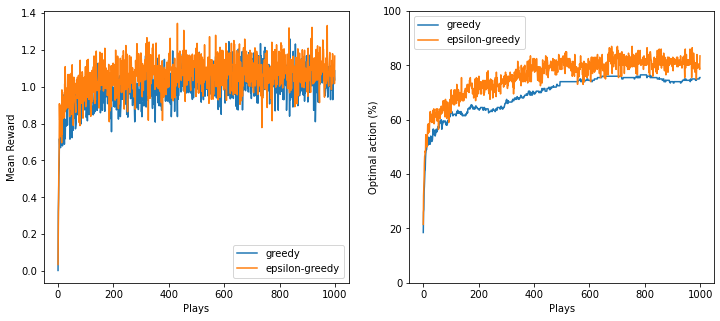

In [6]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_egreedy = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # Select the action greedily w.r.t Q_t
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
            
        # Sample the reward
        r = get_reward(Q_star, a)
        
        # Store the received reward
        rewards_egreedy[trial, step] = r
        
        # Optimal action?
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0            
        
        # Update the Q-value estimate of the action
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**Q:** Compare the properties of greedy and $\epsilon$-greedy (speed, optimality, etc). Vary the value of the parameter $\epsilon$ (0.0001 until 0.5) and conclude.

**A:** Depending on the value of $\epsilon$, $\epsilon$-greedy can perform better that greedy in the end, but will necessitate more time at the beginning. If there is too much exploration, $\epsilon$-greedy can be even worse than greedy. 

## Softmax action selection

To avoid exploring actions which are clearly not optimal, another useful algorithm is **softmax action selection**. In this scheme, the estimated Q-values are ransformed into a probability distribution using the softmax opertion:

$$
    \pi(a) = \frac{\exp \frac{Q_t(a)}{\tau}}{ \sum_b \exp \frac{Q_t(b)}{\tau}}
$$ 

For each action, the term $\exp \frac{Q_t(a)}{\tau}$ is proportional to $Q_t(a)$ but made positive. These terms are then normalized by the denominator in order to obtain a sum of 1, i.e. they are the parameters of a discrete probability distribution. The temperature $\tau$ controls the level of exploration just as $\epsilon$ for $\epsilon$-greedy.

In practice, $\exp \frac{Q_t(a)}{\tau}$ can be very huge if the Q-values are high or the temperature is small, creating numerical instability (NaN). It is much more stable to substract the maximal Q-value from all Q-values before applying the softmax:

$$
    \pi(a) = \frac{\exp \displaystyle\frac{Q_t(a) - \max_a Q_t(a)}{\tau}}{ \sum_a \exp \displaystyle\frac{Q_t(a) - \max_a Q_t(a)}{\tau}}
$$ 

This way, $Q_t(a) - \max_a Q_t(a)$ is always negative, so its exponential is between 0 and 1.

**Q:** Implement the softmax action selection (with $\tau=0.5$ at first) and compare its performance to greedy and $\epsilon$-greedy. Vary the temperature $\tau$ and find the best possible value. Conclude.


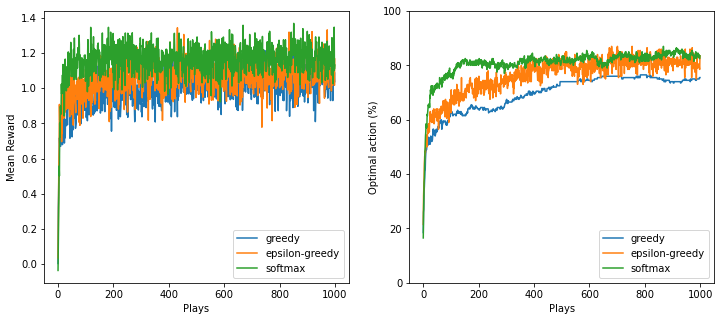

In [7]:
# Learning rate
alpha = 0.1

# Exploration
tau = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_softmax = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # Select the action with softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
            
        # Sample the reward
        r = get_reward(Q_star, a)
        
        # Store the received reward
        rewards_softmax[trial, step] = r
        
        # Optimal action?
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        
        # Update the Q-value estimate of the action
        Q_softmax[a] += alpha * (r - Q_softmax[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** softmax loses less time than $\epsilon$-greedy exploring the really bad solutions, so it is optimal earlier. It can be more efficient and optimal than the other methods, but finding the right value for $\tau$ (0.1 works well) is difficult: its optimum value depends on the scaling of Q, you cannot know it in advance...

The problem with this version of softmax (with a constant temperature) is that even after it has found the optimal action, it will still explore the other ones (although more rarely than at the beginning). The solution is to **schedule** the exploration parameter so that it explores a lot at the beginning (high temperature) and gradually switches to more exploitation (low temperature).

Many schemes are possible for that, the simplest one being to linearly decrease the temperature so that it starts with a value $\tau_\text{init}$ and reaches $\tau_\text{final}$ at the end of the 1000 plays:

$$\tau = \tau_\text{init} + (\tau_\text{final} - \tau_\text{init}) \, (\frac{t}{1000})$$

**Q:** Implement temperature scheduling for the softmax algorithm ($\epsilon$-greedy would be similar) with $\tau_\text{init}=0.3$ and $\tau_\text{init} = 0.001$. Use different initial and final values. Conclude.

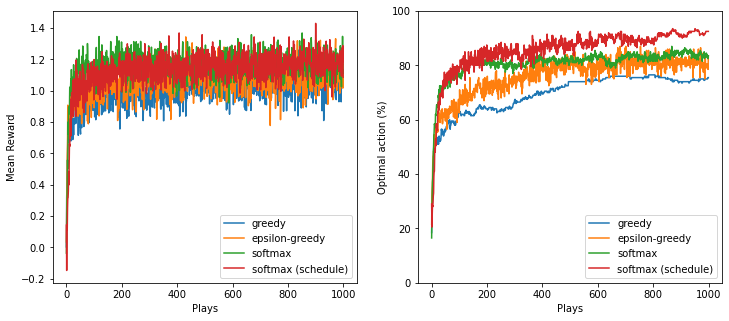

In [8]:
# Learning rate
alpha = 0.1

# Exploration
tau_init = 0.3
tau_final = 0.001

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_softmax_schedule = np.zeros((nb_trials, nb_steps))
optimal_softmax_schedule = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_softmax_schedule = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # Scheduling of tau
        tau = tau_init + (tau_final - tau_init)*(step/nb_steps)
        
        # Select the action with softmax            
        logit = np.exp((Q_softmax_schedule - Q_softmax_schedule.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
            
        # Sample the reward
        r = get_reward(Q_star, a)
        
        # Store the received reward
        rewards_softmax_schedule[trial, step] = r
        
        # Optimal action?
        if a == a_star:
            optimal_softmax_schedule[trial, step] = 1.0            
        
        # Update the Q-value estimate of the action
        Q_softmax_schedule[a] += alpha * (r - Q_softmax_schedule[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.plot(np.mean(rewards_softmax_schedule, axis=0), label="softmax (scheduled)")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.plot(np.mean(100*optimal_softmax_schedule, axis=0), label="softmax (scheduled)")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

## Reward distribution

We are now going to vary the reward distributions and investigate whether the experimental results we had previously when the true Q-values are in $\mathcal{N}(0, 1)$ and the rewards have a variance of 1 still hold.

**Q:** If it is not the case already, create a new cell allowing to perform greedy, $\epsilon$-greedy and softmax action selection (1000 steps, 200 runs) at the same time. Use the best values you have found so far for $\epsilon$ and $\tau$ (no scheduling).

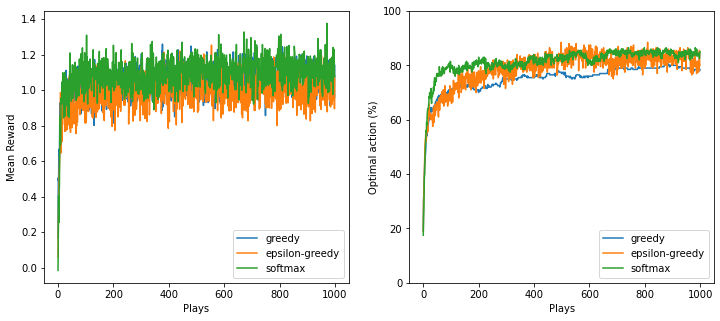

In [9]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = np.zeros(nb_actions)
    Q_egreedy = np.zeros(nb_actions)
    Q_softmax = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**Q:** Let's now change the distribution of true Q-values from $\mathcal{N}(0, 1)$ to $\mathcal{N}(10, 10)$ and re-run the algorithms. What happens and why? Modify the values of `epsilon` and `tau` to try to get a better behavior.

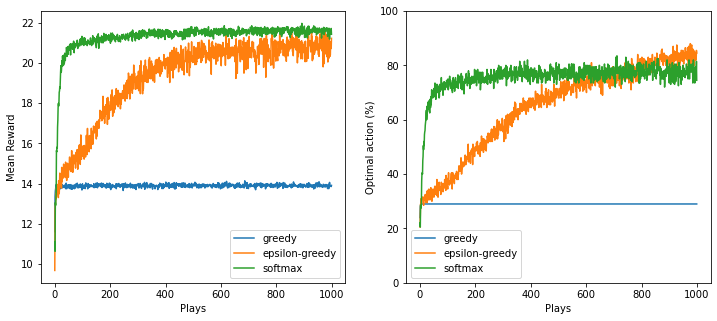

In [10]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 3.0

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(10, 10, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = np.zeros(nb_actions)
    Q_egreedy = np.zeros(nb_actions)
    Q_softmax = np.zeros(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if np.random.rand() < epsilon:
            a = np.random.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** Greedy does not work anymore and stays at chance level. The first action it samples will probably have a non-zero reward, so its estimated Q-value becomes positive (initial estimate of 0) and it will stay the greedy action all along.

$\epsilon$-greedy still works quite well (perhaps a bit slower as the estimates must go from 0 to 10), even with its default value of 0.1.

Softmax does not work unless you increase the temperature to 3 or so. The correct value of `tau` depends on the scaling of the Q-values, so it has to be adapted to every new problem, contrary to $\epsilon$-greedy. But with the correct value of `tau`, you get a good solution much earlier.

## Optimistic initialization

The initial estimates of 0 are now very **pessimistic** compared to the average reward you can get (10). This was not the case in the original setup.

**Q:** Let's change the initial value of the estimates to 10 for each action for each algorithm. What happens? Conclude on the importance of reward scaling.

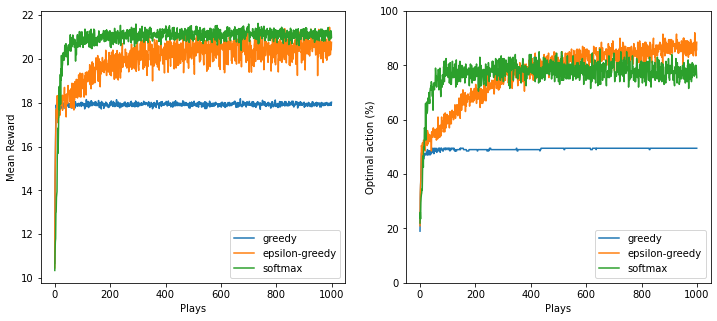

In [11]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 3.0

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(10, 10, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = 10*np.ones(nb_actions)
    Q_egreedy = 10*np.ones(nb_actions)
    Q_softmax = 10*np.ones(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** Now we are back to quite the same results as before (greedy might still be worse, but not at chance level anymore). This shows the importance of **reward scaling**: the amplitude of the rewards influences a lot the success of the different methods ($\epsilon$-greedy is more robust). This mean you need to know the mean expected reward in advance, but you are not supposed to know that as you have not sampled anything at the beginning...

Let's now use **optimistic initialization**, i.e. initialize the estimates to a much higher value than what is realistic.

**Q:** Implement optimistic initialization by initializing the estimates of all three algorithms to 20. What happens?

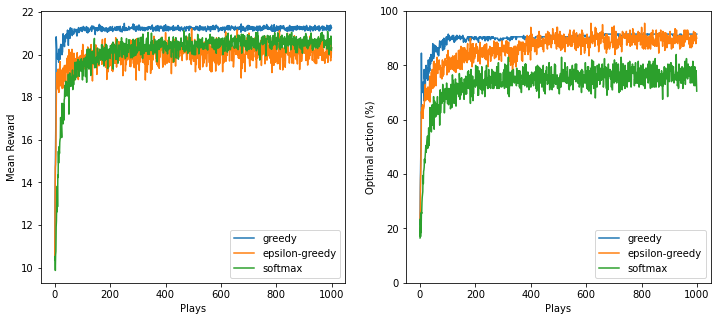

In [12]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 3.0

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(10, 10, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = 20*np.ones(nb_actions)
    Q_egreedy = 20*np.ones(nb_actions)
    Q_softmax = 20*np.ones(nb_actions)
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** with optimistic initialization, greedy action selection becomes the most efficient method: exploration is ensured by the fact that all actions be be executed at some point, as they can only be disappointing. The received rewards are always lower than the expectation at the beginning, so there is no need for additional exploration mechanisms. But it necessitates to know in advance what the maximal reward is...

## Reinforcement comparison

The problem with the previous **value-based** methods is that the Q-value estimates depend on the absolute magnitude of the rewards (by definition). The hyperparameters of the learning algorithms (learning rate, exploration, initial values) will therefore be very different depending on the scaling of the rewards (between 0 and 1, between -100 and 100, etc).

A way to get rid of this dependency is to introduce **preferences** $p_t(a)$ for each action instead of the estimated Q-values. Preferences should follow the Q-values: an action with a high Q-value should have a high Q-value and vice versa, but we do not care about its exact scaling.

In **reinforcement comparison**, we introduce a baseline $\tilde{r}_t$ which is the average received reward **regardless the action**, i.e. there is a single value for the whole problem. This average reward is simply updated after each action with a moving average of the received rewards:

$$\tilde{r}_{t+1} = \tilde{r}_{t} + \alpha \, (r_t - \tilde{r}_{t})$$

The average reward is used to update the preference for the action that was just executed:

$$p_{t+1}(a_t) = p_{t}(a_t) + \beta \, (r_t - \tilde{r}_{t})$$

If the action lead to more reward than usual, its preference should be increased (good surprise). If the action lead to less reward than usual, its preference should be decreased (bad surprise).

Action selection is simply a softmax over the preferences, without the temperature parameter (as we do not care about the scaling):

$$
    \pi (a) = \frac{\exp p_t(a)}{ \sum_b \exp p_t(b)}
$$ 

**Q:** Implement reinforcement comparison (with $\alpha=\beta=0.1$) and compare it to the other methods. 

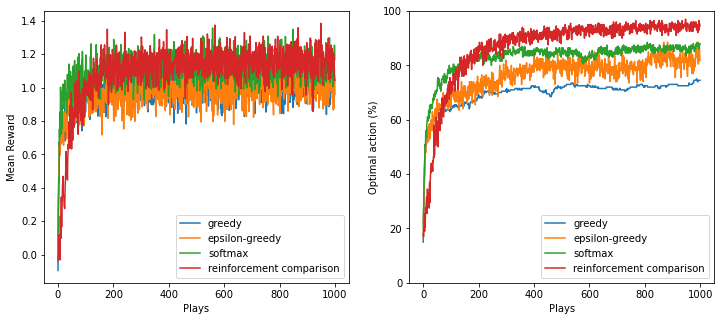

In [13]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 0.1
alpha_rc = 0.1
beta_rc = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

rewards_rc = np.zeros((nb_trials, nb_steps))
optimal_rc = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(0, 1, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = np.zeros(nb_actions)
    Q_egreedy = np.zeros(nb_actions)
    Q_softmax = np.zeros(nb_actions)
    p_rc = np.zeros(nb_actions)
    mean_reward = 0.0
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
        
        # Reinforcement comparison            
        logit = np.exp((p_rc - p_rc.max()))
        proba_rc = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_rc) 
        r = get_reward(Q_star, a)
        rewards_rc[trial, step] = r
        if a == a_star:
            optimal_rc[trial, step] = 1.0            
        p_rc[a] += beta_rc * (r - mean_reward)        
        mean_reward += alpha_rc * (r - mean_reward)
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.plot(np.mean(rewards_rc, axis=0), label="reinforcement comparison")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.plot(np.mean(100*optimal_rc, axis=0), label="reinforcement comparison")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((0,100))
plt.legend()
plt.show()

**A:** RC is slower at the beginning, but ends up being more optimal. We never estimate the Q-values, but we do not care about them, we only want to perform the correct actions. We also get rid of the temperature parameter.

**Q:** Compare all methods with optimistic initialization. The true Q-values come from $\mathcal{N}(10, 10)$, the estimated Q-values are initialized to 20 for greedy, $\epsilon$-greedy and softmax, and the average reward is initialized to 20 for RC (the preferences are initialized at 0).  

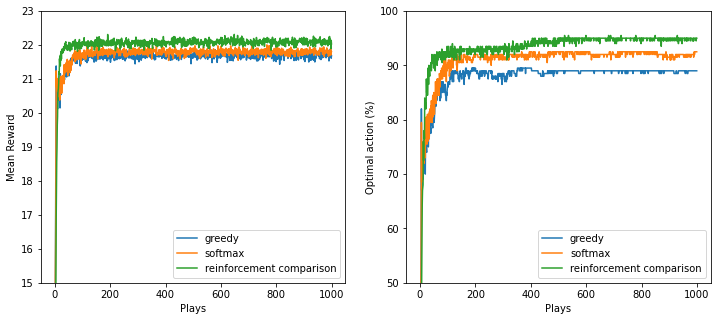

In [14]:
# Learning rate
alpha = 0.1

# Exploration
epsilon = 0.1
tau = 0.1
alpha_rc = 0.1
beta_rc = 0.1

# Setup
nb_trials = 200
nb_steps = 1000

# Store all received rewards and the optimality in a big matrix
rewards_greedy = np.zeros((nb_trials, nb_steps))
optimal_greedy = np.zeros((nb_trials, nb_steps))

rewards_egreedy = np.zeros((nb_trials, nb_steps))
optimal_egreedy = np.zeros((nb_trials, nb_steps))

rewards_softmax = np.zeros((nb_trials, nb_steps))
optimal_softmax = np.zeros((nb_trials, nb_steps))

rewards_rc = np.zeros((nb_trials, nb_steps))
optimal_rc = np.zeros((nb_trials, nb_steps))

# 200 runs
for trial in range(nb_trials):
    
    # True Q-values
    Q_star = rng.normal(10, 10, nb_actions)
    a_star = rng.choice(np.where(Q_star == Q_star.max())[0])
    
    # Estimates
    Q_greedy = 20*np.ones(nb_actions)
    Q_egreedy = 20*np.ones(nb_actions)
    Q_softmax = 20*np.ones(nb_actions)
    p_rc = np.zeros(nb_actions)
    mean_reward = 20.0
    
    # For 1000 plays
    for step in range(nb_steps):    
        
        # greedy
        a = rng.choice(np.where(Q_greedy == Q_greedy.max())[0])
        r = get_reward(Q_star, a)
        rewards_greedy[trial, step] = r
        if a == a_star:
            optimal_greedy[trial, step] = 1.0 
        Q_greedy[a] += alpha * (r - Q_greedy[a])
        
        # epsilon-greedy
        a = rng.choice(np.where(Q_egreedy == Q_egreedy.max())[0])
        if rng.random() < epsilon:
            a = rng.choice(actions[actions !=a])
        r = get_reward(Q_star, a)
        rewards_egreedy[trial, step] = r
        if a == a_star:
            optimal_egreedy[trial, step] = 1.0 
        Q_egreedy[a] += alpha * (r - Q_egreedy[a])
        
        # Softmax            
        logit = np.exp((Q_softmax - Q_softmax.max())/tau)
        proba_softmax = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_softmax) 
        r = get_reward(Q_star, a)
        rewards_softmax[trial, step] = r
        if a == a_star:
            optimal_softmax[trial, step] = 1.0            
        Q_softmax[a] += alpha * (r - Q_softmax[a])
        
        # Reinforcement comparison            
        logit = np.exp((p_rc - p_rc.max()))
        proba_rc = logit / np.sum(logit)
        a = rng.choice(actions, p=proba_rc) 
        r = get_reward(Q_star, a)
        rewards_rc[trial, step] = r
        if a == a_star:
            optimal_rc[trial, step] = 1.0            
        p_rc[a] += beta_rc * (r - mean_reward)        
        mean_reward += alpha_rc * (r - mean_reward)
    
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.mean(rewards_greedy, axis=0), label="greedy")
# plt.plot(np.mean(rewards_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(rewards_softmax, axis=0), label="softmax")
plt.plot(np.mean(rewards_rc, axis=0), label="reinforcement comparison")
plt.xlabel("Plays")
plt.ylabel("Mean Reward")
plt.ylim((15,23))
plt.legend()
plt.subplot(122)
plt.plot(np.mean(100*optimal_greedy, axis=0), label="greedy")
# plt.plot(np.mean(100*optimal_egreedy, axis=0), label="epsilon-greedy")
plt.plot(np.mean(100*optimal_softmax, axis=0), label="softmax")
plt.plot(np.mean(100*optimal_rc, axis=0), label="reinforcement comparison")
plt.xlabel("Plays")
plt.ylabel("Optimal action (%)")
plt.ylim((50,100))
plt.legend()
plt.show()